In [ ]:
#Createvirtualenv
!python -m venv /content/myenv
!source /content/myenv/bin/activate

#Install exact versions
!pip install \
    fsspec==2025.3.0 \
    protobuf==5.26.1 \
    google-auth==2.38.0 \
    decorator==4.4.2 \
    google-cloud-storage==2.8.0

#Install other packages
!pip install gcsfs datasets tensorflow
#Install additional required libraries
!pip install bert-score -q

Error: Command '['/content/myenv/bin/python3', '-m', 'ensurepip', '--upgrade', '--default-pip']' returned non-zero exit status 1.
/bin/bash: line 1: /content/myenv/bin/activate: No such file or directory
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.8/302.8 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.6/113.6 kB 10.8 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.4
    Uninstalling protobuf-5.29.4:
      Successfully uninstalled protobuf-5.29.4
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: google-cloud-storage
    Found existing installation: google-cloud-storage 2.19.0
    Uninstalling google-cloud-storage-2.19.0:
      Successfully uninstalled google-cloud-storage-2.19.0
ERROR: pip's depend

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.4/194.4 kB 12.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-nvrtc-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requi

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Install required libraries (same as before)
!pip install transformers datasets evaluate accelerate -q
!pip install rouge-score -q

#Import modules
from datasets import load_dataset
from transformers import (
    T5Tokenizer,
    T5ForConditionalGeneration,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
    DataCollatorForSeq2Seq
)
import evaluate
import torch
import numpy as np

# Additional imports
import matplotlib.pyplot as plt
from bert_score import score as bert_score
from google.colab import drive


# Dataset loading
import pandas as pd
from datasets import Dataset, DatasetDict

train_df = pd.read_json('/content/drive/MyDrive/summary/train.json')
val_df = pd.read_json('/content/drive/MyDrive/summary/val.json')
test_df = pd.read_json('/content/drive/MyDrive/summary/test.json')

dataset = DatasetDict({
    'train': Dataset.from_pandas(train_df),
    'validation': Dataset.from_pandas(val_df),
    'test': Dataset.from_pandas(test_df)
})

#Initialize T5 tokenizer and model
tokenizer = T5Tokenizer.from_pretrained("t5-base")
model = T5ForConditionalGeneration.from_pretrained("t5-base")

# Modified preprocess function for T5
def preprocess_function(examples):
    # Add T5's required task prefix
    inputs = ["summarize: " + dialogue.replace('\r', '\n') for dialogue in examples["dialogue"]]

    model_inputs = tokenizer(
        inputs,
        max_length=512,
        truncation=True,
    )

    # T5 needs the same tokenizer for labels
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            examples["summary"],
            max_length=64,
            truncation=True,
        )

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_dataset = dataset.map(preprocess_function, batched=True)


data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer,
    model=model,
    padding="longest"
)

# Metrics function
rouge = evaluate.load("rouge")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    rouge_result = rouge.compute(
        predictions=decoded_preds,
        references=decoded_labels,
        use_stemmer=True
    )

    bleu = evaluate.load("bleu")
    bleu_result = bleu.compute(
        predictions=decoded_preds,
        references=[[label] for label in decoded_labels]
    )

    return {
        **{k: round(v * 100, 4) for k, v in rouge_result.items()},
        "bleu": round(bleu_result["bleu"] * 100, 4)
    }

# Training arguments
training_args = Seq2SeqTrainingArguments(
    output_dir="t5-samsum",
    eval_strategy="epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=2,
    weight_decay=0.01,
    save_strategy="epoch",
    num_train_epochs=5,
    predict_with_generate=True,
    fp16=True,
    logging_steps=100,
    optim="adafactor",
    report_to="none"
)

# Initialize Trainer with T5 model
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    data_collator=data_collator
)

# Training and evaluation
trainer.train()
results = trainer.evaluate(tokenized_dataset["test"])
print(results)



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Map:   0%|          | 0/14732 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3980: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/818 [00:00<?, ? examples/s]

Map:   0%|          | 0/819 [00:00<?, ? examples/s]

<ipython-input-5-9d60528bffbb>:118: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Bleu
1,1.591300,1.454762,46.732300,22.653000,39.018600,39.058400,12.775500
2,1.514900,1.416507,47.471100,23.528900,39.754700,39.780800,12.730400
3,1.473400,1.409332,47.838500,24.116500,40.378200,40.417000,13.373800
4,1.529800,1.462879,46.754200,22.695800,39.038500,39.024200,11.986700
5,1.530600,1.459976,46.774100,22.678300,39.028800,39.027300,11.997500


{'eval_loss': 1.4685202836990356, 'eval_rouge1': 45.3843, 'eval_rouge2': 20.5141, 'eval_rougeL': 37.3966, 'eval_rougeLsum': 37.3888, 'eval_bleu': 11.0904, 'eval_runtime': 87.121, 'eval_samples_per_second': 9.401, 'eval_steps_per_second': 1.182, 'epoch': 5.0}


In [ ]:
#save MODEL
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Define the directory where to save the model
save_dir = "/content/drive/MyDrive/t5_summarization_model"

# Create the directory if it doesn't exist
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Save the trained model and tokenizer
model.save_pretrained(save_dir)
tokenizer.save_pretrained(save_dir)

print(f"Model and tokenizer saved to {save_dir}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model and tokenizer saved to /content/drive/MyDrive/t5_summarization_model


In [ ]:
#When you want to reuse the model without retraining, run this:
from google.colab import drive
from transformers import T5Tokenizer, T5ForConditionalGeneration
import os

# Mount Google Drive
drive.mount('/content/drive')

# Define the directory where the model is saved
model_dir = "/content/drive/MyDrive/t5_summarization_model"

# Load the tokenizer and model
tokenizer = T5Tokenizer.from_pretrained(model_dir)
model = T5ForConditionalGeneration.from_pretrained(model_dir)

print("Model and tokenizer loaded successfully!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model and tokenizer loaded successfully!


In [ ]:
# # downloadable model backup
# !zip -r /content/t5_model.zip /content/drive/MyDrive/t5_summarization_model
# from google.colab import files
# files.download("/content/t5_model.zip")

In [ ]:
#Generate predictions and compute BERTScore after training
# Generate test set predictions
test_results = trainer.evaluate(tokenized_dataset["test"])

# Get predictions and labels
predictions = trainer.predict(tokenized_dataset["test"])
preds = predictions.predictions
labels = predictions.label_ids

# Decode texts - handle None values properly
decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

# Filter out any None values that might still exist
decoded_preds = [pred for pred in decoded_preds if pred is not None]
decoded_labels = [label for label in decoded_labels if label is not None]

# Make sure we have matching lengths
min_length = min(len(decoded_preds), len(decoded_labels))
decoded_preds = decoded_preds[:min_length]
decoded_labels = decoded_labels[:min_length]

# Compute BERTScore
P, R, F1 = bert_score(decoded_preds, decoded_labels, lang="en")
bert_score_result = {
    "bert_score_precision": round(P.mean().item() * 100, 4),
    "bert_score_recall": round(R.mean().item() * 100, 4),
    "bert_score_f1": round(F1.mean().item() * 100, 4)
}

# Combine all results
final_results = {**test_results, **bert_score_result}
print("\nFinal Evaluation Results:")
for k, v in final_results.items():
    print(f"{k}: {v}")

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Final Evaluation Results:
eval_loss: 1.4685202836990356
eval_rouge1: 45.3843
eval_rouge2: 20.5141
eval_rougeL: 37.3966
eval_rougeLsum: 37.3888
eval_bleu: 11.0904
eval_runtime: 116.1806
eval_samples_per_second: 7.049
eval_steps_per_second: 0.887
epoch: 5.0
bert_score_precision: 91.7391
bert_score_recall: 89.9898
bert_score_f1: 90.8385


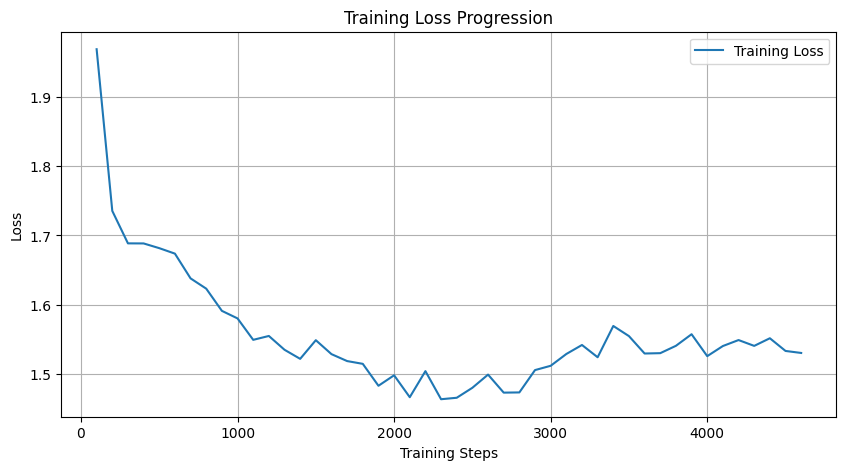

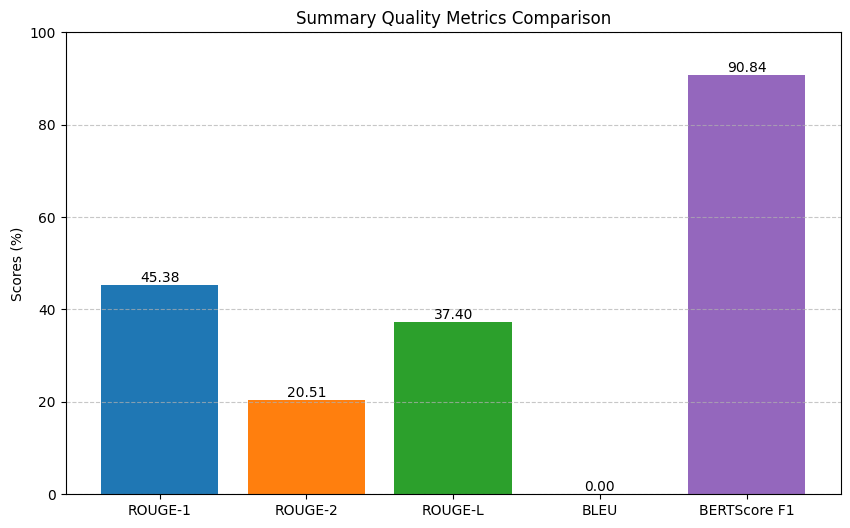

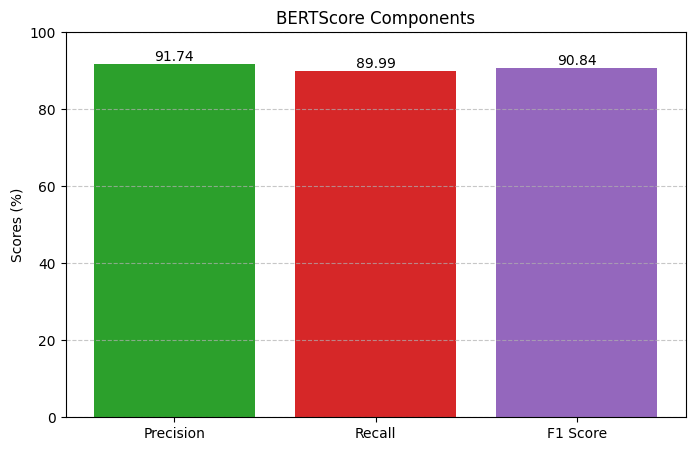

In [ ]:
#Visualization
# Plot training loss
plt.figure(figsize=(10, 5))
train_loss = [log['loss'] for log in trainer.state.log_history if 'loss' in log]
steps = [log['step'] for log in trainer.state.log_history if 'loss' in log]

plt.plot(steps, train_loss, label='Training Loss')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.title('Training Loss Progression')
plt.legend()
plt.grid(True)
plt.show()

# Plot metrics comparison - with error handling
metrics = {}
possible_rouge_keys = ['rouge1', 'rouge2', 'rougeL', 'eval_rouge1', 'eval_rouge2', 'eval_rougeL']

# Find which ROUGE keys actually exist in results
rouge_keys_in_results = [key for key in possible_rouge_keys if key in final_results]

if rouge_keys_in_results:
    # Use the first matching key pattern found
    rouge_prefix = rouge_keys_in_results[0].replace('rouge1', '')  # Gets 'eval_' if present

    metrics.update({
        'ROUGE-1': final_results.get(f'{rouge_prefix}rouge1', 0),
        'ROUGE-2': final_results.get(f'{rouge_prefix}rouge2', 0),
        'ROUGE-L': final_results.get(f'{rouge_prefix}rougeL', 0),
    })

# Add other metrics that might exist
other_metrics = {
    'BLEU': final_results.get('bleu', 0),
    'BERTScore F1': final_results.get('bert_score_f1', 0)
}
metrics.update(other_metrics)

# Only plot if we have at least one metric
if metrics:
    plt.figure(figsize=(10, 6))
    bars = plt.bar(metrics.keys(), metrics.values(), color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])

    plt.ylabel('Scores (%)')
    plt.title('Summary Quality Metrics Comparison')
    plt.ylim(0, 100)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Add values on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.2f}',
                 ha='center', va='bottom')

    plt.show()
else:
    print("No metrics available for visualization")

# Plot BERTScore components if available
if all(key in final_results for key in ['bert_score_precision', 'bert_score_recall', 'bert_score_f1']):
    bert_components = {
        'Precision': final_results['bert_score_precision'],
        'Recall': final_results['bert_score_recall'],
        'F1 Score': final_results['bert_score_f1']
    }

    plt.figure(figsize=(8, 5))
    bars = plt.bar(bert_components.keys(), bert_components.values(), color=['#2ca02c', '#d62728', '#9467bd'])

    plt.ylabel('Scores (%)')
    plt.title('BERTScore Components')
    plt.ylim(0, 100)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.2f}',
                 ha='center', va='bottom')

    plt.show()
else:
    print("BERTScore components not available for visualization")

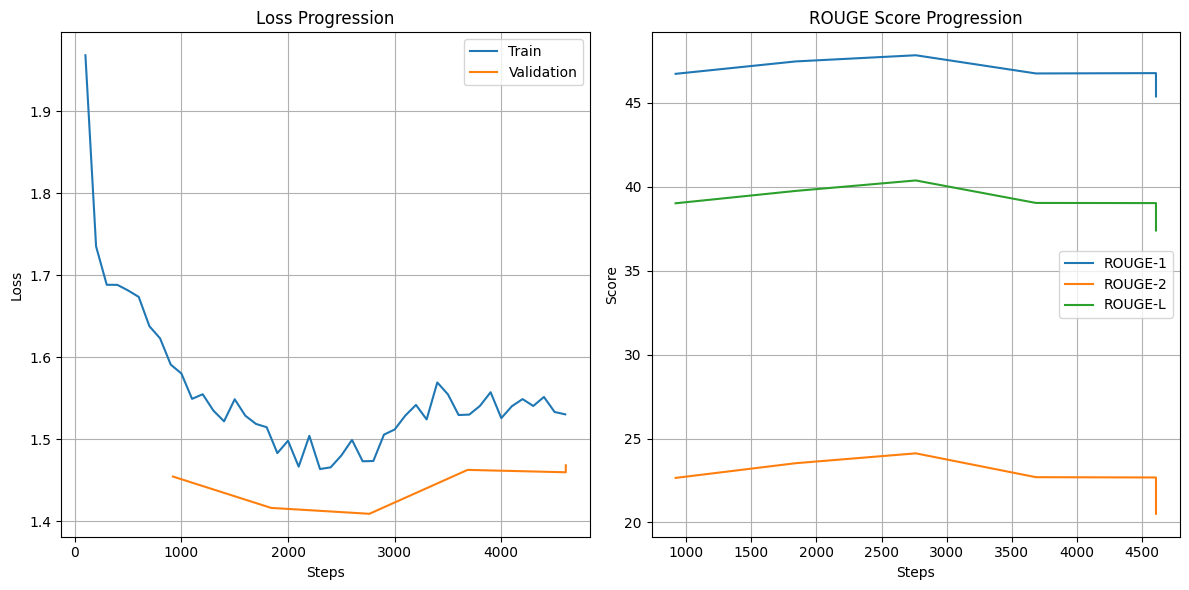

In [ ]:
# 1. Combined Training & Validation Metrics
plt.figure(figsize=(12, 6))

# Extract metrics from log history
log_history = trainer.state.log_history
train_metrics = [x for x in log_history if 'loss' in x]
eval_metrics = [x for x in log_history if 'eval_loss' in x]

# Plot loss
plt.subplot(1, 2, 1)
plt.plot([x['step'] for x in train_metrics], [x['loss'] for x in train_metrics], label='Train')
plt.plot([x['step'] for x in eval_metrics], [x['eval_loss'] for x in eval_metrics], label='Validation')
plt.title('Loss Progression')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot ROUGE scores if available
if 'eval_rouge1' in eval_metrics[0]:
    plt.subplot(1, 2, 2)
    plt.plot([x['step'] for x in eval_metrics], [x['eval_rouge1'] for x in eval_metrics], label='ROUGE-1')
    plt.plot([x['step'] for x in eval_metrics], [x['eval_rouge2'] for x in eval_metrics], label='ROUGE-2')
    plt.plot([x['step'] for x in eval_metrics], [x['eval_rougeL'] for x in eval_metrics], label='ROUGE-L')
    plt.title('ROUGE Score Progression')
    plt.xlabel('Steps')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

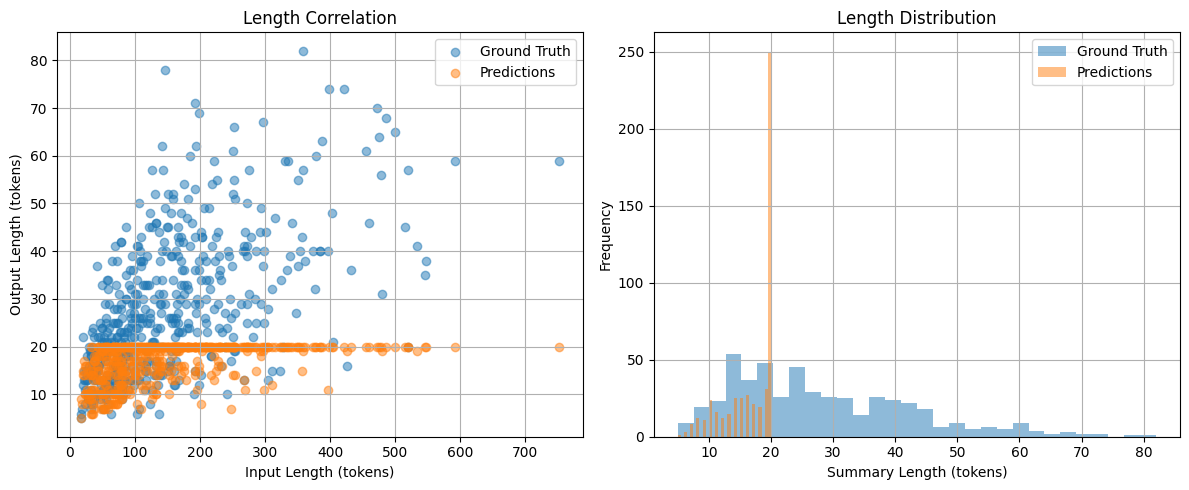

In [ ]:
# 2. Input-Output Length Relationship
plt.figure(figsize=(12, 5))

# Calculate lengths
input_lengths = [len(tokenizer.tokenize(x)) for x in dataset['test']['dialogue'][:500]]
output_lengths = [len(tokenizer.tokenize(x)) for x in dataset['test']['summary'][:500]]
pred_lengths = [len(tokenizer.tokenize(x)) for x in decoded_preds[:500]]

# Scatter plot
plt.subplot(1, 2, 1)
plt.scatter(input_lengths, output_lengths, alpha=0.5, label='Ground Truth')
plt.scatter(input_lengths, pred_lengths, alpha=0.5, label='Predictions')
plt.xlabel('Input Length (tokens)')
plt.ylabel('Output Length (tokens)')
plt.title('Length Correlation')
plt.legend()
plt.grid(True)

# Length distribution
plt.subplot(1, 2, 2)
plt.hist(output_lengths, bins=30, alpha=0.5, label='Ground Truth')
plt.hist(pred_lengths, bins=30, alpha=0.5, label='Predictions')
plt.xlabel('Summary Length (tokens)')
plt.ylabel('Frequency')
plt.title('Length Distribution')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
#Qualitative Examples Display
from IPython.display import HTML
import random

sample_indices = random.sample(range(len(decoded_preds)), 5)
examples = []
for idx in sample_indices:
    examples.append({
        "Input": dataset['test']['dialogue'][idx][:150] + "...",
        "Reference": decoded_labels[idx],
        "Prediction": decoded_preds[idx],
        "ROUGE-L": rouge.compute(
            predictions=[decoded_preds[idx]],
            references=[decoded_labels[idx]],
            use_stemmer=True)['rougeL']
    })

# Create HTML table
html = "<table><tr><th>Input</th><th>Reference</th><th>Prediction</th><th>ROUGE-L</th></tr>"
for ex in examples:
    html += f"""
    <tr>
        <td style='max-width:200px;word-wrap:break-word'>{ex['Input']}</td>
        <td style='max-width:200px;word-wrap:break-word'>{ex['Reference']}</td>
        <td style='max-width:200px;word-wrap:break-word'>{ex['Prediction']}</td>
        <td>{ex['ROUGE-L']*100:.1f}%</td>
    </tr>
    """
html += "</table>"
display(HTML(html))

Input,Reference,Prediction,ROUGE-L
"Ollie: Okay, Kelly! Ur up nxt! Kelly: Me? I don't wanna. Mickey: C'mon! Jessica: Yeah! What's yours? Kelly: Fine. It's a sculpture garden in Finnl...","Kelly is scared of sculpture garden figures in Finnland, she finds figure's faces morbid. For Ollie it's Nagoro village in Japan, it's creepy.",Kelly is going to Nagoro village in Japan.,35.3%
"Charles: What are you up to this weekend? Camilla: Not much. Just some work and errands on Saturday, show Saturday night. Day of nothingness on Sundy...",Camilla has some errands to do on Saturday. Charles is visiting the German markets this weekend. They are talking about Christmas food and drinks.,Camilla is going to visit the German markets this weekend. She's not going to do much,39.0%
"Abby: Have you talked to Miro? Dylan: No, not really, I've never had an opportunity Brandon: me neither, but he seems a nice guy Brenda: you met hi...",Miro speaks Albanian with his parents. His family left Albania illegally in 1990s.,Miro's father came from Albania to the US in the early 1990s. He told Ab,27.6%
Shaldona: WE ARE GONNA GET MARRIED ❤️❤️ Shaldona: Shaldona: This is our mobile inviation for our wedding. Shaldona: Invitation* Piper: H...,"Shaldona sends mobile invitations to her wedding, as she has no time to give them in person.",Shaldona sent Piper her invitation card. She didn't have time to meet everyone,32.3%
Emily: fancy a drink after work today? Kate: sure! Marta: Good idea! Marta: Where? When? Emily: Maybe in the Pub X at the central station at 5.30...,"Emily, Kate and Marta are going to the Pub X at the central station today for a drink.",Kate and Marta will meet in the Pub X at the central station at 5.30.,58.8%


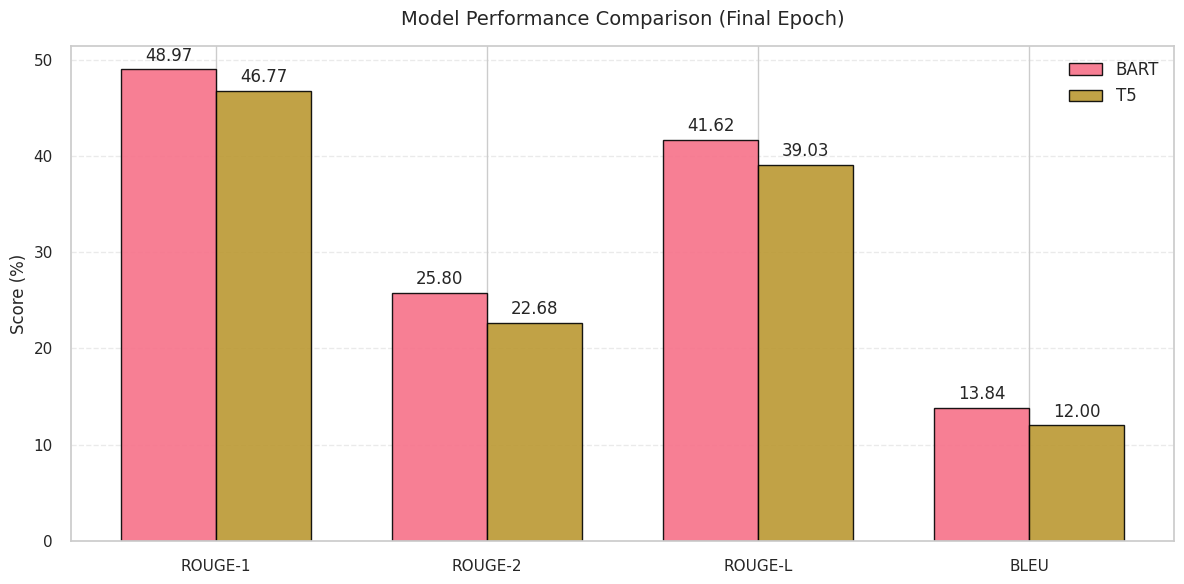

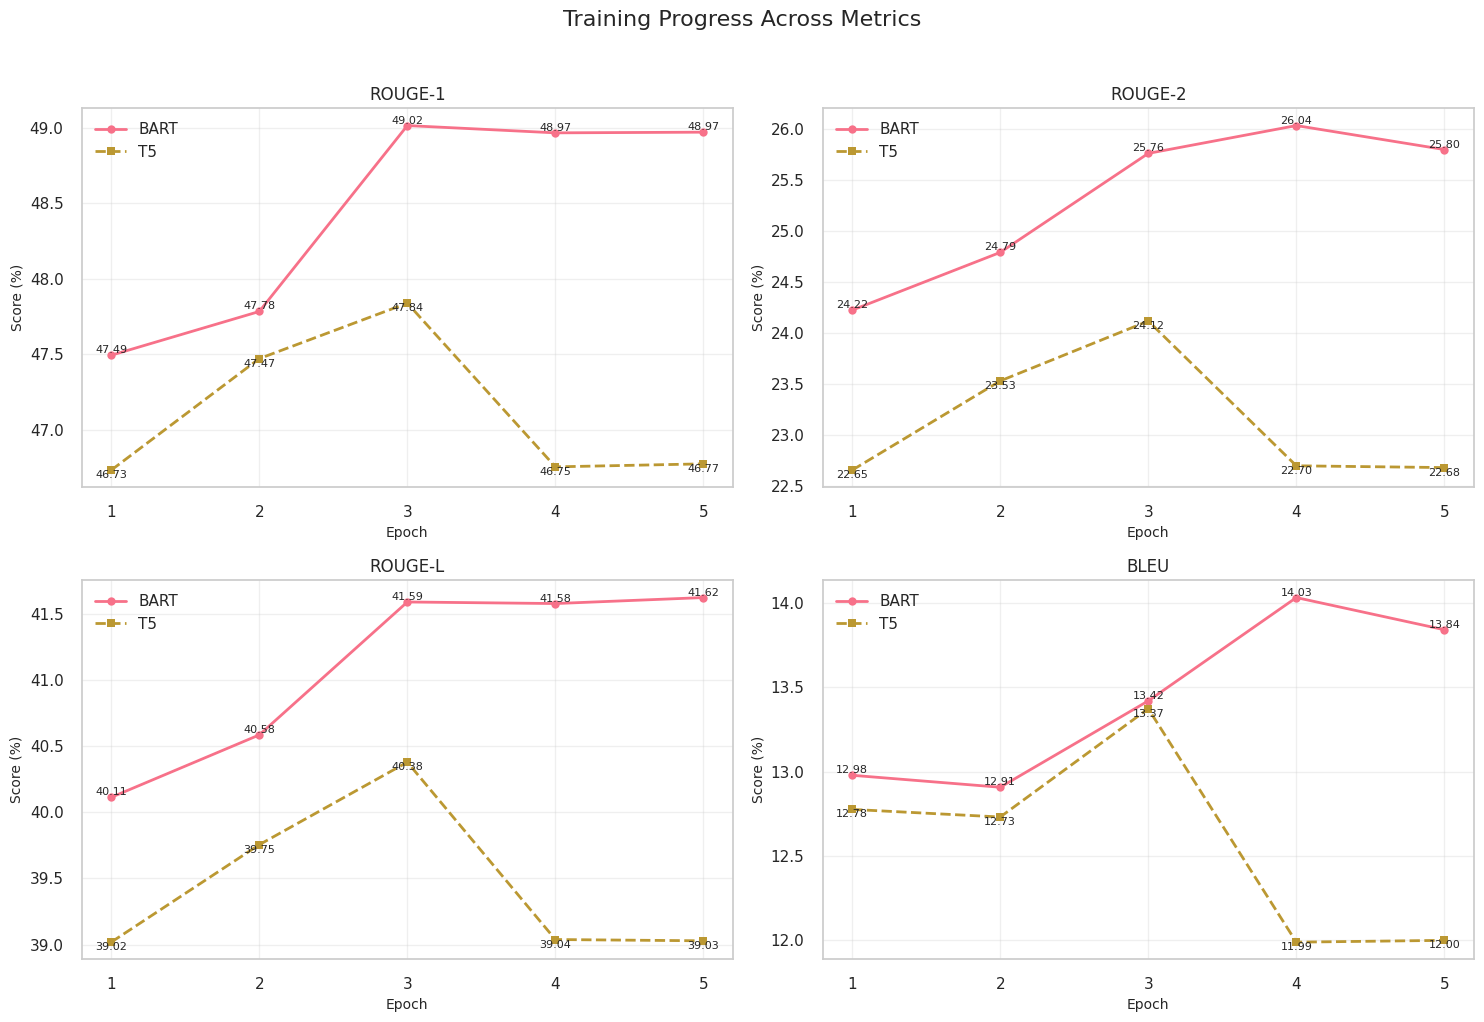

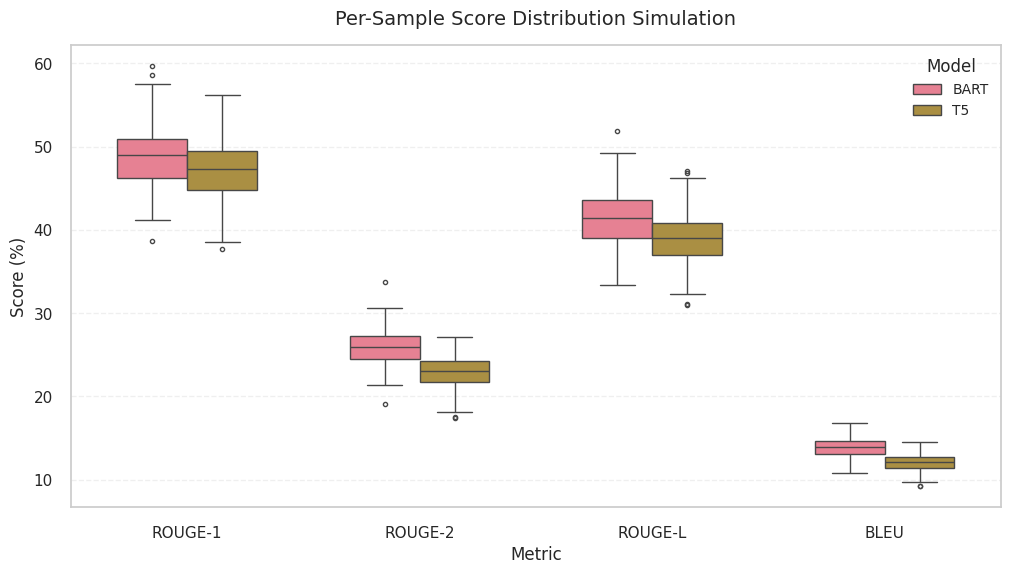

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np


plt.style.use('seaborn-v0_8')
sns.set_theme(style="whitegrid", palette="husl")

# T5 Metrics
t5_metrics = {
    'Epoch': [1, 2, 3, 4, 5],
    'Training Loss': [1.591300, 1.514900, 1.473400, 1.529800, 1.530600],
    'Validation Loss': [1.454762, 1.416507, 1.409332, 1.462879, 1.459976],
    'ROUGE-1': [46.732300, 47.471100, 47.838500, 46.754200, 46.774100],
    'ROUGE-2': [22.653000, 23.528900, 24.116500, 22.695800, 22.678300],
    'ROUGE-L': [39.018600, 39.754700, 40.378200, 39.038500, 39.028800],
    'BLEU': [12.775500, 12.730400, 13.373800, 11.986700, 11.997500]
}

# BART Metrics
bart_metrics = {
    'Epoch': [1, 2, 3, 4, 5],
    'Training Loss': [1.773000, 1.605400, 1.479500, 1.374600, 1.300400],
    'Validation Loss': [1.571202, 1.527714, 1.505980, 1.500513, 1.499407],
    'ROUGE-1': [47.493600, 47.783400, 49.015000, 48.966700, 48.971200],
    'ROUGE-2': [24.223500, 24.790400, 25.762400, 26.035500, 25.800000],
    'ROUGE-L': [40.112700, 40.584000, 41.588100, 41.576300, 41.621500],
    'BLEU': [12.978300, 12.907200, 13.420400, 14.034300, 13.843000]
}

# Convert to DataFrames
t5_df = pd.DataFrame(t5_metrics)
bart_df = pd.DataFrame(bart_metrics)

# 1. BAR CHART - Final Epoch Comparison

plt.figure(figsize=(12, 6))

metrics = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'BLEU']
x = np.arange(len(metrics))
width = 0.35

# Get final epoch values
bart_final = bart_df.iloc[-1][metrics].values
t5_final = t5_df.iloc[-1][metrics].values

plt.bar(x - width/2, bart_final, width, label='BART', edgecolor='black', alpha=0.9)
plt.bar(x + width/2, t5_final, width, label='T5', edgecolor='black', alpha=0.9)

plt.title('Model Performance Comparison (Final Epoch)', fontsize=14, pad=15)
plt.ylabel('Score (%)', fontsize=12)
plt.xticks(x, metrics)
plt.legend(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.4)

# Add value labels
for i, (b_val, t_val) in enumerate(zip(bart_final, t5_final)):
    plt.text(i - width/2, b_val + 0.5, f'{b_val:.2f}', ha='center', va='bottom')
    plt.text(i + width/2, t_val + 0.5, f'{t_val:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# 2. LINE PLOTS - Training Progress

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Training Progress Across Metrics', fontsize=16, y=1.02)

metrics = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'BLEU']
epochs = bart_df['Epoch']

for ax, metric in zip(axes.flat, metrics):
    ax.plot(epochs, bart_df[metric], 'o-', label='BART', linewidth=2)
    ax.plot(epochs, t5_df[metric], 's--', label='T5', linewidth=2)

    ax.set_title(metric, fontsize=12)
    ax.set_xlabel('Epoch', fontsize=10)
    ax.set_ylabel('Score (%)', fontsize=10)
    ax.set_xticks(epochs)
    ax.legend()
    ax.grid(alpha=0.3)

    # Add value annotations
    for epoch, b_val, t_val in zip(epochs, bart_df[metric], t5_df[metric]):
        ax.text(epoch, b_val, f'{b_val:.2f}', ha='center', va='bottom', fontsize=8)
        ax.text(epoch, t_val, f'{t_val:.2f}', ha='center', va='top', fontsize=8)

plt.tight_layout()
plt.show()

# 3. BOX PLOTS - Score Distribution

# Simulate per-sample scores (replace with your actual data if available)
np.random.seed(42)
n_samples = 200

data = []
for model, df in [('BART', bart_df), ('T5', t5_df)]:
    for metric in ['ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'BLEU']:
        mean_val = df[metric].iloc[-1]  # Final epoch value
        std_dev = mean_val * 0.08  # 8% standard deviation
        scores = np.random.normal(mean_val, std_dev, n_samples)
        data.extend([{'Model': model, 'Metric': metric, 'Score': s} for s in scores])

dist_df = pd.DataFrame(data)

plt.figure(figsize=(12, 6))
sns.boxplot(x='Metric', y='Score', hue='Model', data=dist_df,
            width=0.6, linewidth=1, fliersize=3)
plt.title('Per-Sample Score Distribution Simulation', fontsize=14, pad=15)
plt.ylabel('Score (%)', fontsize=12)
plt.xlabel('Metric', fontsize=12)
plt.legend(title='Model', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.show()

